## Here is my awsome notebook
Look particularly at my $\pi_0$ calculations

In [8]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import pandas as pd

def generate_expression_data(n_analytes=100, n_samples=2, n_replicates=3, p_regulated=0.2, mean_offset=3.0, var=0.2, diff_var=2.0):
    # Here we follow a convension, The first sample is the reference i.e. have all label 1
    labels = npr.binomial(1, p_regulated, (n_analytes,n_samples-1))
    template = np.hstack((np.zeros((n_analytes,1)),labels))
    
    # We expand the template labels into several replicates
    regulated = np.repeat(template,n_replicates, axis=1)
    
    # If the reading is regulated, offset it with a random offset sampled from the normal distribution 
    offset = regulated*npr.normal(0,diff_var,(n_analytes,1))
    
    # Model a differentexpression level for the different analytes
    expr_level = np.ones((n_analytes,n_samples*n_replicates))*npr.normal(mean_offset,mean_offset,(n_analytes,1))
    
    # add noice for each measurement
    expression = npr.normal(offset+expr_level,var,(n_analytes,n_replicates*n_samples))
    expression = 2**expression
    
    analyte_names = ["a"+str(i+1) for i in range(n_analytes)]
    sample_names = ["s"+str(i+1)+'_'+str(j+1) for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe for expression values
    expr_df = pd.DataFrame(expression,columns=sample_names,index=analyte_names)
    expr_df.loc["Sample",:] = [i+1 for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe with answers if the reading was modeled as differential or not
    label_df = pd.DataFrame(template,columns=[i+1 for i in range(n_samples)],index=analyte_names)
                
    return expr_df,label_df


In [21]:
def bootstrap(invec):
    idx = npr.randint(0, len(invec), len(invec))
    return [invec[i] for i in idx]

def estimatePi0(p, numBoot=100, numLambda=100, maxLambda=0.95):
    p.sort()
    n=len(p)
    lambdas=np.linspace(maxLambda/numLambda,maxLambda,numLambda)
    Wls=np.array([n-np.argmax(p>=l) for l in lambdas])
    pi0s=np.array([Wls[i] / (n * (1 - lambdas[i])) for i in range(numLambda)])
    minPi0=np.min(pi0s)
    mse = np.zeros(numLambda)
    for boot in range(numBoot):
        pBoot = bootstrap(p)
        pBoot.sort()
        WlsBoot =np.array([n-np.argmax(pBoot>=l) for l in lambdas])
        pi0sBoot =np.array([WlsBoot[i] / (n *(1 - lambdas[i])) for i in range(numLambda)])
        mse = mse + np.square(pi0sBoot-minPi0)
    minIx = np.argmin(mse)
    return pi0s[minIx]

def qvalues(pvalues):
    m=len(pvalues)
    pvalues.sort()
    pi0 = estimatePi0([p for p,coord in pvalues])
    num_p, p_sum, qs = 0.0, 0.0, []
    for p,coord in pvalues:
        num_p += 1.0
        q = pi0*p*m/num_p
        qs.append((q,p,coord))
    qs.reverse()
    old_q=1.0
    for ix in range(len(qs)):
        q = min(old_q,qs[ix][0])
        old_q = q
        qs[ix] = (q,qs[ix][1],qs[ix][2])
    qs.reverse()
    return qs

In [22]:
from scipy.stats import ttest_ind

def get_pvalue_two_groups(row):
    return (ttest_ind(row[0:3],row[3:6])[1],row.name)

expression,labels = generate_expression_data(10000)
pv = expression.apply(get_pvalue_two_groups,axis=1).tolist()
qv = qvalues(pv)

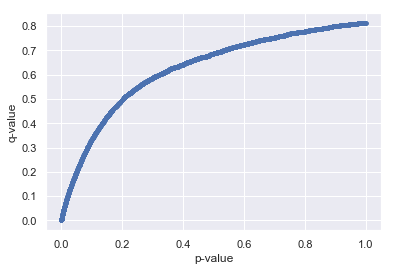

In [17]:
import matplotlib.pyplot as plt
plt.plot([q[1] for q in qv],[q[0] for q in qv],'b.')
plt.xlabel("p-value")
plt.ylabel("q-value")
plt.show()

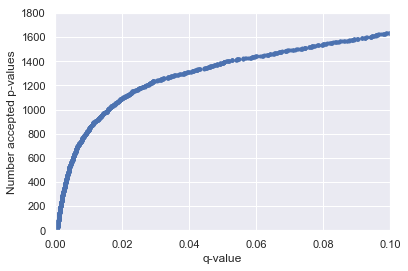

In [18]:
plt.plot([q[0] for q in qv],range(len(qv)),'b.')
plt.ylabel("Number accepted p-values")
plt.xlabel("q-value")
plt.xlim(0,0.1)
plt.ylim(0,1800)
plt.show()

/Users/lukask/miniconda3/envs/abi/lib/python3.6/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


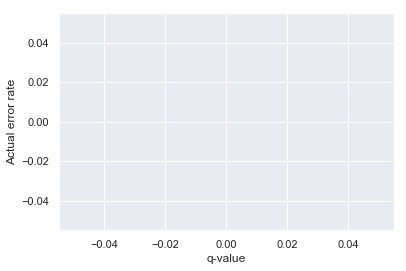

In [23]:
number_of_errors,number_stat_above_threshold = 0.0,0.0
error_rates,ixs = [],[q[2] for q in qv]
for is_regulated in (labels.loc[ixs,2]):
    number_of_errors += (1.0-is_regulated)
    number_stat_above_threshold += 1.0 
    error_rates.append(number_of_errors/number_stat_above_threshold)
plt.plot([q[0] for q in qv],error_rates,'b-')
plt.xlabel("q-value")
plt.ylabel("Actual error rate")
plt.show()

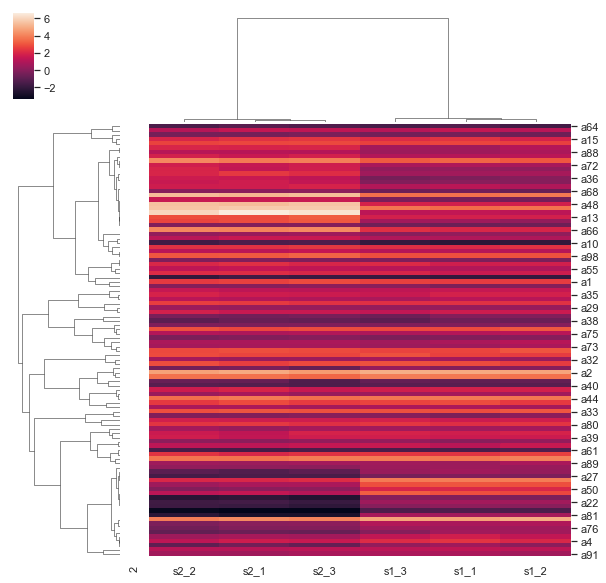

In [20]:
expression,labels = generate_expression_data(100,mean_offset=2.0,p_regulated=0.5)
import seaborn as sns; sns.set(color_codes=True)
lut = dict(zip("01", "rb"))
row_colors = labels[2].map(lut)
expression = expression.drop("Sample").apply(np.log)
g = sns.clustermap(expression,metric="correlation",method='complete',row_colors=row_colors)
